In [1]:
import csv, sys, pickle, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

### Data Parsing, Processing, Feature Making

In [2]:
# Get data
with open('./data_split.pkl') as f:
    TRAINDATA, VALDATA, TESTDATA = pickle.load(f)
print TRAINDATA[0].keys()

['', 'cut', 'color', 'clarity', 'price', 'carat', 'depth', 'table', 'y', 'x', 'z']


In [13]:
# PREPROCESS: define averages and onehots
AVERAGES = [0.0]*6 # [carat,depth,table,x,y,z]
for d in TRAINDATA:
    AVERAGES[0] += float(d['carat'])
    AVERAGES[1] += float(d['depth'])
    AVERAGES[2] += float(d['table'])
    AVERAGES[3] += float(d['x'])
    AVERAGES[4] += float(d['y'])
    AVERAGES[5] += float(d['z'])

AVERAGES = [c/len(TRAINDATA) for c in AVERAGES]

# TO ONE HOT.
#  1. one hot for cut [0:Fair, 1:Good, 2:Very Good, 3:Premium, 4:Ideal]
#  2. one hot color [0:J, 1:I, 2:H, 3:G, 4:F, 5:E, 6:D]
#  3. one hot clarity [0:I1,1:SI2,2:SI1,3:VS2,4:VS1,5:VVS2,6:VVS1,7:IF]
cut2idx = {'Fair': 0,'Good': 1,'Very Good': 2,'Premium': 3,'Ideal': 4 }
color2idx = {'J': 0,'I': 1,'H': 2,'G': 3,'F': 4,'E': 5,'D': 6 }
clarity2idx = {'I1': 0,'SI2': 1,'SI1': 2,'VS2': 3,'VS1': 4,'VVS2': 5,'VVS1': 6, 'IF': 7}
def toOneHot(exDict):
    cut,col,cla = [0.0]*5, [0.0]*7, [0.0]*8
    cut[cut2idx[exDict['cut']]] = 1.0
    col[color2idx[exDict['color']]] = 1.0
    cla[clarity2idx[exDict['clarity']]] = 1.0
    return cut,col,cla

# [label | cut | color | clarity || carat | depth | table | x | y | z]
def createFeature(listDicts):
    feats = []
    for i in range(len(listDicts)):
        if float(listDicts[i]['x']) < 10**-5 or \
        float(listDicts[i]['y']) < 10**-5 or \
        float(listDicts[i]['z']) < 10**-5:
            continue
        lab = [float(listDicts[i]['price'])]
        cut,col,cla = toOneHot(listDicts[i])
        tmp = []
        tmp.append(float(listDicts[i]['carat']) - AVERAGES[0])
        tmp.append(float(listDicts[i]['depth']) - AVERAGES[1])
        tmp.append(float(listDicts[i]['table']) - AVERAGES[2])
        tmp.append(float(listDicts[i]['x'])*float(listDicts[i]['x'])*float(listDicts[i]['x']))
        #tmp.append(float(listDicts[i]['x']) - AVERAGES[3])
        #tmp.append(float(listDicts[i]['y']) - AVERAGES[4])
        #tmp.append(float(listDicts[i]['z']) - AVERAGES[5])
        feats.append(lab + cut + col + cla + tmp)
    return feats

trainFeat = np.array(createFeature(TRAINDATA))
valFeat = np.array(createFeature(VALDATA))
testFeat = np.array(createFeature(TESTDATA))

### Network Definitions

In [17]:
### Parameters
NUM_FEAT = len(trainFeat[0]) - 1
LAYER_WIDTHS = [NUM_FEAT,100,100,1] #[# features, # layer1 nodes, # layer2 nodes ... ]

NUM_EPOCHS = 500
BATCH_SIZE = 100
LR = 0.004
DECAY_AFTER_EPOCH = 200
NUM_EPOCHS_TO_DECAY = 50
DECAY = 0.5

In [20]:
### Network architecture
class Net_100_100(nn.Module):
    def __init__(self,numfeat):
        super(Net_100_100,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.FC1 = nn.Linear(numfeat,100)
        self.FC2 = nn.Linear(100,100)
        self.FC3 = nn.Linear(100,1)
        
    def forward(self,x):
        x = self.sigmoid(self.FC1(x))
        x = self.sigmoid(self.FC2(x))
        x = self.FC3(x)
        return x
    
class Net_200_100(nn.Module):
    def __init__(self,numfeat):
        super(Net_200_100,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.FC1 = nn.Linear(numfeat,200)
        self.FC2 = nn.Linear(200,100)
        self.FC3 = nn.Linear(100,1)
        
    def forward(self,x):
        x = self.sigmoid(self.FC1(x))
        x = self.sigmoid(self.FC2(x))
        x = self.FC3(x)
        return x
    
    
net = Net_200_100(NUM_FEAT)

### Train

In [21]:
### Helper Functions
def saveModel(net):
    # save model
    print '\nSaving Model..'
    torch.save(net, './catOnlyModel.pt')
    print 'Done saving model..'
def get_L_R2(net,listFeats):
    Rscore = 0.0
    totloss = 0.0
    numBatches = 0

    idxList = range(len(listFeats))
    while(len(idxList)>0):
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = listFeats[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())
        
        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)
        
        # forward pass
        outData = net(inData)
        loss = criterion(outData,label)
        totloss += loss.data[0]
        
        # get error
        outData = outData.cpu().data.numpy()
        label = label.cpu().data.numpy()
        Rscore += r2_score(outData,label)
        
        numBatches += 1
                
    return totloss/numBatches, Rscore/numBatches
def adjust_learning_rate(optimizer, decay, lr):
    print 'Adjusting learning rate from %.6f to %.6f' % (lr,lr*decay)
    lr = lr * decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

### Define Net and Train
net = net.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

trainLoss, trainR2 = [],[]
valLoss,valR2 = [],[]

for epoch in range(NUM_EPOCHS):
    
    print '\n=========================='
    print 'Starting Epoch {}'.format(epoch+1)
    print '=========================='
    
    # stats
    if epoch > 100:
        vl,vr2 = get_L_R2(net,valFeat)
        print 'Validation loss: %.4f'% (vl)
        print 'Validation R2 Score: %.4f' % (vr2)
        valLoss.append(vl)
        valR2.append(vr2)
        tl,tr2 = get_L_R2(net,trainFeat)
        print 'Train loss: %.4f'% (tl)
        print 'Train R2 Score: %.4f' % (tr2)
        trainLoss.append(tl)
        trainR2.append(tr2)
    
    # adjust learning rate
    if epoch >= DECAY_AFTER_EPOCH and epoch % NUM_EPOCHS_TO_DECAY == 0:
        LR = adjust_learning_rate(optimizer, DECAY, LR)
    
    # Backprop
    idxList = range(len(trainFeat))
    random.shuffle(idxList)
    iterCount = 0
    while(len(idxList)>0):
        
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = trainFeat[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())

        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)

        # train
        optimizer.zero_grad()
        outData = net(inData)
        loss = criterion(outData,label)
        loss.backward()
        optimizer.step()

        iterCount += 1
        
saveModel(net)



Starting Epoch 1

Starting Epoch 2

Starting Epoch 3

Starting Epoch 4

Starting Epoch 5

Starting Epoch 6

Starting Epoch 7

Starting Epoch 8

Starting Epoch 9

Starting Epoch 10

Starting Epoch 11

Starting Epoch 12

Starting Epoch 13

Starting Epoch 14

Starting Epoch 15

Starting Epoch 16

Starting Epoch 17

Starting Epoch 18

Starting Epoch 19

Starting Epoch 20

Starting Epoch 21

Starting Epoch 22

Starting Epoch 23

Starting Epoch 24

Starting Epoch 25

Starting Epoch 26

Starting Epoch 27

Starting Epoch 28

Starting Epoch 29

Starting Epoch 30

Starting Epoch 31

Starting Epoch 32

Starting Epoch 33

Starting Epoch 34

Starting Epoch 35

Starting Epoch 36

Starting Epoch 37

Starting Epoch 38

Starting Epoch 39

Starting Epoch 40

Starting Epoch 41

Starting Epoch 42

Starting Epoch 43

Starting Epoch 44

Starting Epoch 45

Starting Epoch 46

Starting Epoch 47

Starting Epoch 48

Starting Epoch 49

Starting Epoch 50

Starting Epoch 51

Starting Epoch 52

Starting Epoch 53

S

Train loss: 1727005.5286
Train R2 Score: 0.8240

Starting Epoch 107
Validation loss: 1575038.8819
Validation R2 Score: 0.8571
Train loss: 1682936.7357
Train R2 Score: 0.8509

Starting Epoch 108
Validation loss: 1493844.5936
Validation R2 Score: 0.8599
Train loss: 1592812.1787
Train R2 Score: 0.8546

Starting Epoch 109
Validation loss: 1516582.0133
Validation R2 Score: 0.8427
Train loss: 1614295.5976
Train R2 Score: 0.8378

Starting Epoch 110
Validation loss: 1397492.7057
Validation R2 Score: 0.8629
Train loss: 1485465.7761
Train R2 Score: 0.8588

Starting Epoch 111
Validation loss: 1366542.1853
Validation R2 Score: 0.8677
Train loss: 1450171.7426
Train R2 Score: 0.8640

Starting Epoch 112
Validation loss: 1311890.8077
Validation R2 Score: 0.8798
Train loss: 1393672.8123
Train R2 Score: 0.8759

Starting Epoch 113
Validation loss: 1322965.9492
Validation R2 Score: 0.8878
Train loss: 1406651.5097
Train R2 Score: 0.8836

Starting Epoch 114
Validation loss: 1234618.7501
Validation R2 Score:

Train loss: 445062.6694
Train R2 Score: 0.9690

Starting Epoch 153
Validation loss: 439482.7648
Validation R2 Score: 0.9690
Train loss: 444770.1262
Train R2 Score: 0.9700

Starting Epoch 154
Validation loss: 436872.0620
Validation R2 Score: 0.9692
Train loss: 444749.4255
Train R2 Score: 0.9699

Starting Epoch 155
Validation loss: 417914.5448
Validation R2 Score: 0.9697
Train loss: 420544.1366
Train R2 Score: 0.9708

Starting Epoch 156
Validation loss: 427997.5693
Validation R2 Score: 0.9694
Train loss: 427202.7072
Train R2 Score: 0.9708

Starting Epoch 157
Validation loss: 414841.3121
Validation R2 Score: 0.9690
Train loss: 420118.5904
Train R2 Score: 0.9700

Starting Epoch 158
Validation loss: 485045.7477
Validation R2 Score: 0.9639
Train loss: 479334.4044
Train R2 Score: 0.9662

Starting Epoch 159
Validation loss: 387446.0020
Validation R2 Score: 0.9727
Train loss: 391671.7038
Train R2 Score: 0.9736

Starting Epoch 160
Validation loss: 436605.7962
Validation R2 Score: 0.9701
Train lo


Starting Epoch 199
Validation loss: 324359.4705
Validation R2 Score: 0.9780
Train loss: 324446.7136
Train R2 Score: 0.9791

Starting Epoch 200
Validation loss: 476034.6432
Validation R2 Score: 0.9618
Train loss: 497770.3479
Train R2 Score: 0.9618

Starting Epoch 201
Validation loss: 341603.8468
Validation R2 Score: 0.9755
Train loss: 353910.0591
Train R2 Score: 0.9759
Adjusting learning rate from 0.004000 to 0.002000

Starting Epoch 202
Validation loss: 304007.2980
Validation R2 Score: 0.9791
Train loss: 310347.0623
Train R2 Score: 0.9797

Starting Epoch 203
Validation loss: 300380.0819
Validation R2 Score: 0.9798
Train loss: 309158.8933
Train R2 Score: 0.9801

Starting Epoch 204
Validation loss: 334368.4727
Validation R2 Score: 0.9756
Train loss: 345342.5727
Train R2 Score: 0.9761

Starting Epoch 205
Validation loss: 311110.7534
Validation R2 Score: 0.9782
Train loss: 317770.4402
Train R2 Score: 0.9788

Starting Epoch 206
Validation loss: 317973.4843
Validation R2 Score: 0.9793
Train


Starting Epoch 245
Validation loss: 304424.4888
Validation R2 Score: 0.9799
Train loss: 302538.1081
Train R2 Score: 0.9809

Starting Epoch 246
Validation loss: 310899.8953
Validation R2 Score: 0.9795
Train loss: 311725.0936
Train R2 Score: 0.9804

Starting Epoch 247
Validation loss: 318954.6105
Validation R2 Score: 0.9782
Train loss: 322770.6141
Train R2 Score: 0.9789

Starting Epoch 248
Validation loss: 312494.4818
Validation R2 Score: 0.9789
Train loss: 313869.0718
Train R2 Score: 0.9798

Starting Epoch 249
Validation loss: 302417.0779
Validation R2 Score: 0.9799
Train loss: 307379.1319
Train R2 Score: 0.9805

Starting Epoch 250
Validation loss: 325935.4726
Validation R2 Score: 0.9763
Train loss: 330265.9092
Train R2 Score: 0.9772

Starting Epoch 251
Validation loss: 296147.5088
Validation R2 Score: 0.9803
Train loss: 299321.2100
Train R2 Score: 0.9810
Adjusting learning rate from 0.002000 to 0.001000

Starting Epoch 252
Validation loss: 297412.4758
Validation R2 Score: 0.9801
Train


Starting Epoch 291
Validation loss: 288733.9170
Validation R2 Score: 0.9802
Train loss: 286941.5642
Train R2 Score: 0.9814

Starting Epoch 292
Validation loss: 290237.6730
Validation R2 Score: 0.9798
Train loss: 288964.9373
Train R2 Score: 0.9810

Starting Epoch 293
Validation loss: 295626.0885
Validation R2 Score: 0.9806
Train loss: 293150.9242
Train R2 Score: 0.9816

Starting Epoch 294
Validation loss: 315109.2295
Validation R2 Score: 0.9771
Train loss: 317527.6665
Train R2 Score: 0.9781

Starting Epoch 295
Validation loss: 301025.2083
Validation R2 Score: 0.9803
Train loss: 297886.7912
Train R2 Score: 0.9814

Starting Epoch 296
Validation loss: 295090.0569
Validation R2 Score: 0.9793
Train loss: 294148.5193
Train R2 Score: 0.9805

Starting Epoch 297
Validation loss: 347225.6721
Validation R2 Score: 0.9784
Train loss: 343629.6675
Train R2 Score: 0.9796

Starting Epoch 298
Validation loss: 293203.1144
Validation R2 Score: 0.9797
Train loss: 294133.1136
Train R2 Score: 0.9807

Startin


Starting Epoch 337
Validation loss: 286805.1289
Validation R2 Score: 0.9804
Train loss: 282564.2015
Train R2 Score: 0.9816

Starting Epoch 338
Validation loss: 289367.2465
Validation R2 Score: 0.9801
Train loss: 281563.5871
Train R2 Score: 0.9816

Starting Epoch 339
Validation loss: 283972.9993
Validation R2 Score: 0.9806
Train loss: 278145.0694
Train R2 Score: 0.9820

Starting Epoch 340
Validation loss: 283543.0590
Validation R2 Score: 0.9810
Train loss: 280054.7845
Train R2 Score: 0.9822

Starting Epoch 341
Validation loss: 284310.4444
Validation R2 Score: 0.9805
Train loss: 278375.0901
Train R2 Score: 0.9818

Starting Epoch 342
Validation loss: 287414.6724
Validation R2 Score: 0.9810
Train loss: 280895.2373
Train R2 Score: 0.9823

Starting Epoch 343
Validation loss: 289798.2355
Validation R2 Score: 0.9808
Train loss: 282783.0966
Train R2 Score: 0.9823

Starting Epoch 344
Validation loss: 290906.3011
Validation R2 Score: 0.9808
Train loss: 282290.9207
Train R2 Score: 0.9823

Startin


Starting Epoch 383
Validation loss: 285749.6249
Validation R2 Score: 0.9808
Train loss: 275360.4794
Train R2 Score: 0.9824

Starting Epoch 384
Validation loss: 280970.9883
Validation R2 Score: 0.9807
Train loss: 273398.2113
Train R2 Score: 0.9822

Starting Epoch 385
Validation loss: 285110.5292
Validation R2 Score: 0.9809
Train loss: 274401.6756
Train R2 Score: 0.9825

Starting Epoch 386
Validation loss: 283594.3283
Validation R2 Score: 0.9804
Train loss: 276421.6226
Train R2 Score: 0.9819

Starting Epoch 387
Validation loss: 283175.4455
Validation R2 Score: 0.9808
Train loss: 273110.4643
Train R2 Score: 0.9824

Starting Epoch 388
Validation loss: 283359.9238
Validation R2 Score: 0.9807
Train loss: 273529.2146
Train R2 Score: 0.9823

Starting Epoch 389
Validation loss: 283195.9255
Validation R2 Score: 0.9809
Train loss: 273408.2859
Train R2 Score: 0.9825

Starting Epoch 390
Validation loss: 285348.9894
Validation R2 Score: 0.9804
Train loss: 274693.0843
Train R2 Score: 0.9821

Startin


Starting Epoch 429
Validation loss: 281442.5046
Validation R2 Score: 0.9810
Train loss: 269656.8316
Train R2 Score: 0.9827

Starting Epoch 430
Validation loss: 282662.4290
Validation R2 Score: 0.9805
Train loss: 271974.3033
Train R2 Score: 0.9822

Starting Epoch 431
Validation loss: 282538.4984
Validation R2 Score: 0.9807
Train loss: 270194.8899
Train R2 Score: 0.9825

Starting Epoch 432
Validation loss: 284278.6140
Validation R2 Score: 0.9811
Train loss: 271578.0718
Train R2 Score: 0.9828

Starting Epoch 433
Validation loss: 283095.9400
Validation R2 Score: 0.9811
Train loss: 270883.6961
Train R2 Score: 0.9828

Starting Epoch 434
Validation loss: 280869.9742
Validation R2 Score: 0.9808
Train loss: 270261.7920
Train R2 Score: 0.9825

Starting Epoch 435
Validation loss: 280603.8254
Validation R2 Score: 0.9810
Train loss: 269131.6172
Train R2 Score: 0.9827

Starting Epoch 436
Validation loss: 282166.2051
Validation R2 Score: 0.9811
Train loss: 270627.7958
Train R2 Score: 0.9828

Startin


Starting Epoch 475
Validation loss: 281808.1901
Validation R2 Score: 0.9811
Train loss: 268711.8286
Train R2 Score: 0.9828

Starting Epoch 476
Validation loss: 280576.8433
Validation R2 Score: 0.9810
Train loss: 268103.9769
Train R2 Score: 0.9828

Starting Epoch 477
Validation loss: 282725.1760
Validation R2 Score: 0.9805
Train loss: 271893.3537
Train R2 Score: 0.9822

Starting Epoch 478
Validation loss: 280727.6961
Validation R2 Score: 0.9810
Train loss: 268300.7255
Train R2 Score: 0.9828

Starting Epoch 479
Validation loss: 281671.1878
Validation R2 Score: 0.9810
Train loss: 268402.0883
Train R2 Score: 0.9828

Starting Epoch 480
Validation loss: 281514.4008
Validation R2 Score: 0.9808
Train loss: 268548.9518
Train R2 Score: 0.9826

Starting Epoch 481
Validation loss: 280626.0298
Validation R2 Score: 0.9810
Train loss: 267959.7393
Train R2 Score: 0.9827

Starting Epoch 482
Validation loss: 281420.1484
Validation R2 Score: 0.9811
Train loss: 268513.1185
Train R2 Score: 0.9829

Startin

/opt/conda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net_200_100. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saving predictions to: 100-100_Results.txt
Done saving.
Final Training Rscore: 0.982852
Final Validation Rscore: 0.981082
Final Test Rscore: 0.980192


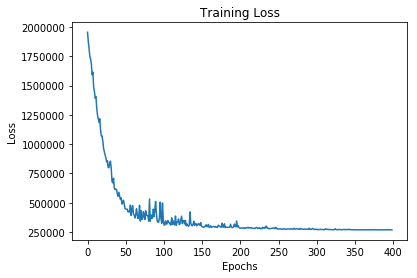

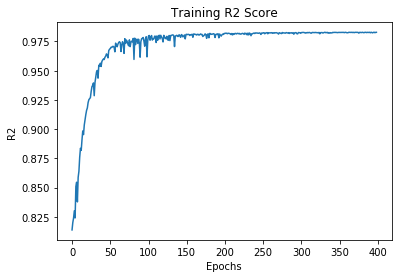

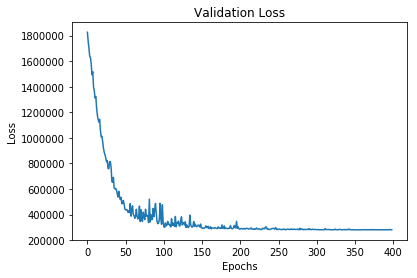

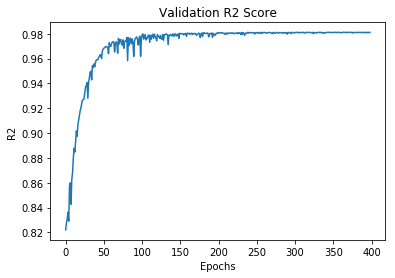

In [22]:
def savePredictions(net,firstline,listFeats,filename):
    print 'Saving predictions to: %s' % filename
    preds = []
    preds.append(firstline)
    preds.append('Predictions | Labels\n')
    preds.append('---------------------\n')
    
    idxList = range(len(listFeats))
    while(len(idxList)>0):
        batchIdxs = []
        for idxz in range(BATCH_SIZE):
            if len(idxList) == 0:
                break
            batchIdxs.append(idxList.pop())
        
        batch_data = listFeats[batchIdxs]
        batch_F = batch_data[:,1:]
        batch_L = batch_data[:,0]
    
        inData = torch.from_numpy(batch_F)
        inData = inData.float()
        inData = Variable(inData.cuda())
        
        label = torch.from_numpy(batch_L)
        label = label.float()
        label = Variable(label.cuda(),requires_grad=False)
        
        # forward pass
        outData = net(inData)
        
        # get error
        outData = outData.cpu().data.numpy()
        label = label.cpu().data.numpy()
        
        for i in range(label.shape[0]):
            preds.append(str(outData[i][0]) + ' ' + str(label[i]) + '\n')
    
    with open(filename,'w') as f:
        for p in preds:
            f.write(p)
    print 'Done saving.'

# test r2 score and save results
_,testR2 = get_L_R2(net,testFeat)
fl = 'Final Test Rscore: ' + str(testR2) + '\n'
savePredictions(net,fl,testFeat,'100-100_Results.txt')
print 'Final Training Rscore: %.6f' % trainR2[-1]
print 'Final Validation Rscore: %.6f' % valR2[-1]
print 'Final Test Rscore: %.6f' % testR2


plt.plot(trainLoss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(trainR2)
plt.title('Training R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.show()

plt.plot(valLoss)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(valR2)
plt.title('Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.show()
